This file is a notebook to perform the AL and DA loop for the normals dataset and for the normals aligner.
Follow these steps:
1) Put the parameter values in the first cell
2) In the folder alignflow_master\data\testdata, fill in the train and test data
3) Run the script
4) Find the plots in the corresponding folders
The versionname decides how the values will be in the.csv files.


In [2]:
versionname = "XalignedAlignFlow-heuristic"
original = False                                    # Do you want plots of the aligned data (False) or of the original data (True)?
al_strategy = "entropy"
k = 100
nbags = 2
bag_contfactor = 1
seed = 1
query_budget = nbags*k# 30# 30*10

In [3]:
## Imports

import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
## Construct dataset
# 15 bags
# 35 instances/bag
import sys
from create_ds_Normals import gen_data

bags, bags_labels, X_inst, y_inst = gen_data(k = k, nbags = nbags, bag_contfactor = bag_contfactor, seed = seed)

In [5]:
y_inst[0:5] = 1.
y_inst[100:105] = 1.
dummy = X_inst[0:5,:]
X_inst[0:5,:] =X_inst[100:105,:]
X_inst[100:105,:] = dummy
dummy = np.array(bags[0][0:5,:])
bags[0][0:5,:] =bags[1][0:5,:]
bags[1][0:5,:] = dummy

'''## REMOVE ANOMALIES
#print(list(y_inst.astype(int)))
print(X_inst.shape)
print(X_inst[y_inst == 0].shape)'''

'## REMOVE ANOMALIES\n#print(list(y_inst.astype(int)))\nprint(X_inst.shape)\nprint(X_inst[y_inst == 0].shape)'

In [7]:
import os, pathlib
current = "C:\\Users\\vanma\\Desktop\\Games\\Maarten\\KU Leuven\\Fase 5\\Master thesis\\code\\ALBA-paper\\src"
print(current)
path = os.path.join(current, "alignflow-master","data", "testdata")
a = "A.csv"
b = "B.csv"
np.savetxt(os.path.join(path, "train"+a), bags[0], delimiter=",")
np.savetxt(os.path.join(path, "train"+b), bags[1], delimiter=",")
np.savetxt(os.path.join(path, "test"+a), bags[0], delimiter=",")
np.savetxt(os.path.join(path, "test"+b), bags[1], delimiter=",")

C:\Users\vanma\Desktop\Games\Maarten\KU Leuven\Fase 5\Semester 2\Master thesis\code\ALBA-paper\src


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\vanma\\Desktop\\Games\\Maarten\\KU Leuven\\Fase 5\\Semester 2\\Master thesis\\code\\ALBA-paper\\src\\alignflow-master\\data\\testdata\\trainA.csv'

In [ ]:
D = bags
bags = np.array(list(D.values()))

In [ ]:
import sys
sys.path.insert(1, '../')
from dataBag import DataBag
from rewardInfo import RewardInfo

dataBag = DataBag(bags, bags_labels, X_inst, y_inst)
rewardInfo = RewardInfo(len(bags_labels))

clrs = ['b','g','r','c','m','k','y', 'lime','deeppink','aqua','yellow','gray','darkorange','saddlebrown','salmon']

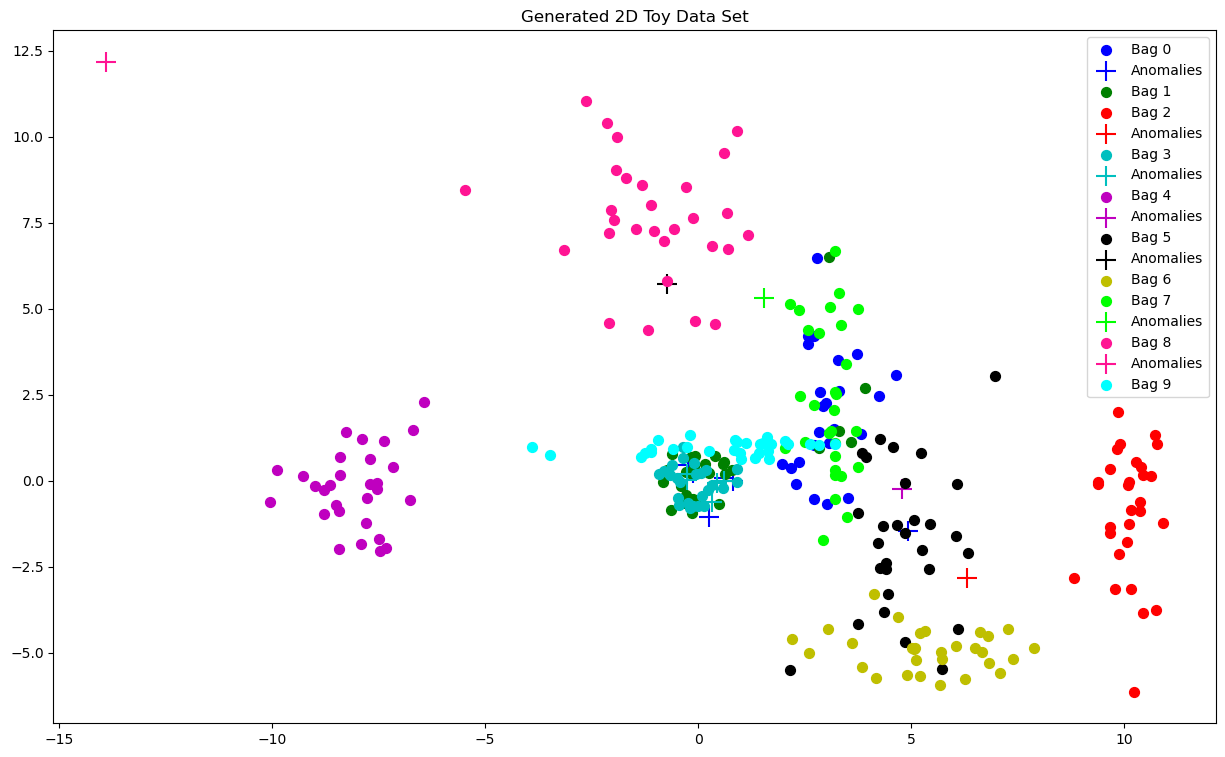

In [ ]:
## Create toy data set

from itertools import cycle
cycol = cycle(clrs)

fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (15,9) )  # create figure & 1 axis

for bag in range(len(bags)):
    domain = bags[bag]
    anomalies = []
    normals = []
    D[bag] = np.asarray(domain.tolist())

    for idx in range(len(domain)):
        if dataBag.isAnomaly(bag, idx):
            anomalies.append(domain[idx])
        else:
            normals.append(domain[idx])

    anomalies = np.asarray(anomalies)
    normals = np.asarray(normals)
    
    c=next(cycol)
    if (len(normals)>0):
        ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label = "Bag "+str(bag))#, c= 'b')
    if (len(anomalies)>0):
        ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies")#,c= 'b')

'''for bag in range(len(bags)):
    domain = bags[bag]
    if (len(domain)>0):
        ax.scatter(domain[:,0], domain[:,1], c=next(cycol))'''
        

#fig.savefig('img/original.png',bbox_inches='tight')
plt.title('Generated 2D Toy Data Set')
plt.legend()
plt.show()
plt.close(fig)


In [ ]:
from data import Data
from methods import MABMethod
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve

def getPrediction(alba: MABMethod, data: Data):
    pos = {}
    neg = {}
    probabilities = alba.predict(data, True)
    return probabilities
    '''for key in predictions.keys():
        posdummy = []
        negdummy = []
        for i in range(len(predictions[key])):
            if predictions[key][i]==-1:
                negdummy.append(data.get_domain(key)[i])
            elif predictions[key][i]==1:
                posdummy.append(data.get_domain(key)[i])
        pos[key] = np.asarray(posdummy)
        neg[key] = np.asarray(negdummy)
    return neg, pos, predictions'''

def diff2dd(A, B):
    # https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [A.dtype]}

    C = np.setdiff1d(A.view(dtype), B.view(dtype))

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def currentPrediction(alba, data, bags, newinstanceKey, instance, labeledPos = None, labeledNeg = None, t=0):
    

    cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 

    


    for bag in range(len(bags)):
        domain = bags[bag]
        pos = np.asarray(labeledPos[bag])
        neg = np.asarray(labeledNeg[bag])
        domain = diff2dd(domain, pos)
        domain = diff2dd(domain, neg)
        c = next(cycol)

        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=c)
        
        if (len(pos)>0):
            ax.scatter(pos[:,0], pos[:,1], marker = '+', c=c)
        if (len(neg)>0):
            ax.scatter(neg[:,0], neg[:,1], marker = '_', c=c)


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('img/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)



    probabilities = getPrediction(alba, data)
    '''nrows = 3
    ncols = 4
    fig, axs = plt.subplots( nrows=nrows, ncols=ncols ,figsize=(16,9)) 
   
    for bag in range(len(bags)):
        ax = axs[bag//ncols, bag-ncols*(bag//ncols)]
        domain = bags[bag]
        ax.scatter(domain[:,0], domain[:,1], c =probabilities[bag], cmap = 'gray')
        if (bag == newinstanceKey):
            ax.scatter(instance[0], instance[1], c='red')


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('colorimg/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)'''




    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 
    domain = np.zeros((0,2))
    prs = np.zeros((0))
    for bag in range(len(bags)):
        domain = np.concatenate((domain,bags[bag]))
        prs = np.concatenate((prs, probabilities[bag]))
    
    z = ax.scatter(domain[:,0], domain[:,1], c = prs  , cmap = 'coolwarm',  s=200, edgecolors='k')
    ax.scatter(instance[0], instance[1],c='lime',label = "Selected instance",s=400, edgecolors='k')


    scoreroc = roc_auc_score(np.rint(y_inst), prs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(y_inst), prs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scorepr = auc(recall, precision)
    
    plt.title('Iteration '+str(t).zfill(3), fontsize = 16)
    rewardInfo.updateAuc("roc", scoreroc)
    rewardInfo.updateAuc("pr", scorepr)

    
    textstr = "ROC AUC = {:.10f}\nPR AUC = {:.10f}".format(scoreroc, scorepr)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props)
    
    cbar = fig.colorbar(z,ax= ax, label ="higher score = more positive")
    tick_font_size = 14
    cbar.ax.tick_params(labelsize=tick_font_size)
    plt.rcParams.update({'font.size': 14})
    ax.legend(loc = "lower right", fontsize= 14)

    fig.savefig('colorimg2/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)


In [ ]:
## Create 2 domains
training_data = Data(nbags)
print(nbags)
print(D)
training_data.set_domains_and_labels(D)
alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = al_strategy)


2
{0: array([[-6.65975833e-01, -4.40288800e-01],
       [-8.80344280e-01, -1.39548861e-01],
       [-8.25360633e-01,  8.11424543e-01],
       [-4.45277792e-01,  6.67633817e-03],
       [-5.59557699e-01, -3.47346798e-01],
       [ 3.85818965e+00, -4.62972177e+00],
       [ 5.47855864e+00, -5.47685030e+00],
       [ 4.62594444e+00, -5.13310925e+00],
       [ 7.19316191e+00, -4.98369273e+00],
       [ 1.90978894e+00, -5.68655866e+00],
       [ 4.51637419e+00, -4.84242030e+00],
       [ 4.42391847e+00, -4.57691968e+00],
       [ 6.70065416e+00, -5.42975797e+00],
       [ 3.35016310e+00, -4.82472701e+00],
       [ 4.74135769e+00, -5.65614171e+00],
       [ 3.68321237e+00, -5.01934775e+00],
       [ 5.06332062e+00, -5.80788618e+00],
       [ 5.87422282e+00, -4.43929115e+00],
       [ 3.34907123e+00, -4.79554973e+00],
       [ 6.71708556e+00, -5.01230848e+00],
       [ 6.35238608e+00, -5.38758081e+00],
       [ 5.75374151e+00, -4.36312203e+00],
       [ 6.35128392e+00, -4.01644913e+00],
     

In [ ]:
if (original):
    t = 0  
    labeledPos = {}
    labeledNeg = {}
    for bag in range(len(bags)):
        labeledNeg[bag] = []
        labeledPos[bag] = []
    performance = []

    import warnings
    warnings.filterwarnings('ignore')

    while(t<query_budget):
        queries = alba.fit_query(training_data, True)

        #!!!!!!!
        key,idx = queries[0]
        i = 0
        while dataBag.isLabeled(key,idx):
            i+=1
            key, idx = queries[i]
            
        rewardInfo.chooseArm(key)
        key,idx = queries[i]
        instance = training_data.get_domain(key)[idx]
        lbl = dataBag.getLabel(key, idx)
        training_data.set_new_label(key, idx, lbl)
        training_data.set_last_labeled(key,idx)
        dataBag.label(key,idx)
        if (lbl == 1):
            labeledPos[key].append(instance.tolist())
        else:
            labeledNeg[key].append(instance.tolist())

        currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, t)
        
        #performance.append(dataBag.measureAccuracy(predictions))
        print(t)
        t += 1

    ## window = 10!!!

In [ ]:
if original:
    import cv2
    import os

    image_folder = 'img'
    video_name = 'videoOriginal.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg'
    video_name = 'videocolorimgOriginal.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg2'
    video_name = 'videocolorimg2Original.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

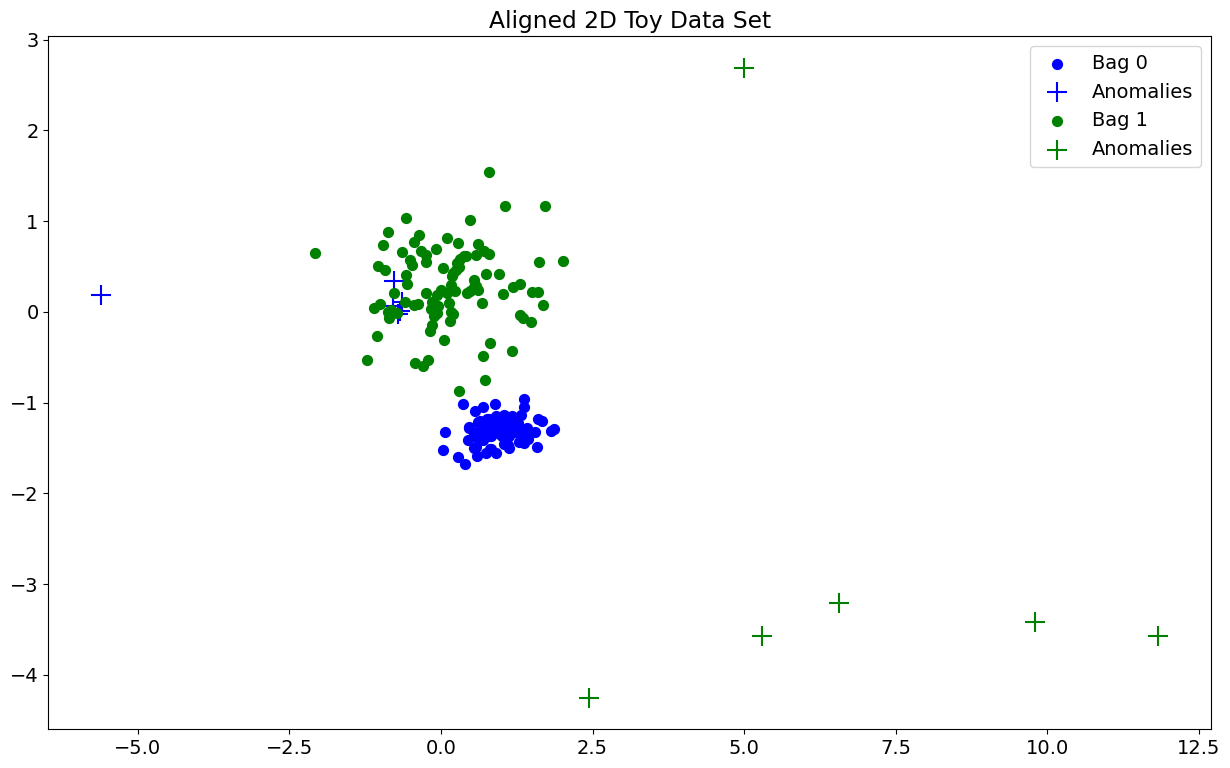

In [ ]:
## NEW !!!
if not original:
    a_data = np.genfromtxt(os.path.join(path, "test"+a), delimiter=',', dtype=np.float32)
    b_data = np.genfromtxt(os.path.join(path, "test"+b), delimiter=',', dtype=np.float32)
    D = {0:a_data, 1: b_data}
    Xinst = np.zeros((0,D[0].shape[1]))
    for key in D:
        Xinst = np.concatenate((Xinst, D[key]))
    bags = np.array(list(D.values()))

    from itertools import cycle
    cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (15,9) )  # create figure & 1 axis

    for bag in range(len(bags)):
        domain = bags[bag]
        anomalies = []
        normals = []
        D[bag] = np.asarray(domain.tolist())

        for idx in range(len(domain)):
            if dataBag.isAnomaly(bag, idx):
                anomalies.append(domain[idx])
            else:
                normals.append(domain[idx])

        anomalies = np.asarray(anomalies)
        normals = np.asarray(normals)
        
        c=next(cycol)
        if (len(normals)>0):
            ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label = "Bag "+str(bag))#, c= 'b')
        if (len(anomalies)>0):
            ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies")#,c= 'b')   

    '''for bag in range(len(bags)):
        domain = bags[bag]
        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=next(cycol))'''
            

    #fig.savefig('img/original.png',bbox_inches='tight')
    plt.title('Aligned 2D Toy Data Set')
    plt.legend()
    plt.show()
    plt.close(fig)


In [ ]:
## Create 2 domains
if not original:
    training_data = Data(nbags)
    print(nbags)
    print(D)
    training_data.set_domains_and_labels(D)
    alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = al_strategy)


2
{0: array([[-0.70925128, -0.02074534],
       [-0.78339255,  0.06532669],
       [-0.77373487,  0.3374961 ],
       [-0.6379351 ,  0.10717646],
       [-0.67445302,  0.00585474],
       [ 0.61405027, -1.21976459],
       [ 1.0339911 , -1.46221364],
       [ 0.81155592, -1.36383462],
       [ 1.54422712, -1.32107151],
       [ 0.03730799, -1.52223229],
       [ 0.79318351, -1.28063917],
       [ 0.77825409, -1.20465267],
       [ 1.37694728, -1.44873583],
       [ 0.46232292, -1.2755754 ],
       [ 0.82107878, -1.51352704],
       [ 0.55019093, -1.33127594],
       [ 0.90317118, -1.55695629],
       [ 1.20202565, -1.1652633 ],
       [ 0.4629516 , -1.26722479],
       [ 1.40774679, -1.32926142],
       [ 1.28236783, -1.43666458],
       [ 1.17162693, -1.14346349],
       [ 1.36614704, -1.04424536],
       [ 0.59913403, -1.59161663],
       [ 0.89978451, -1.14884293],
       [ 0.55481541, -1.09282088],
       [ 0.81693208, -1.27736902],
       [ 1.11566186, -1.49735451],
       [ 0.646

In [ ]:
if not original:
    t = 0  
    labeledPos = {}
    labeledNeg = {}
    for bag in range(len(bags)):
        labeledNeg[bag] = []
        labeledPos[bag] = []
    performance = []

    import warnings
    warnings.filterwarnings('ignore')

    while(t<query_budget):
        queries = alba.fit_query(training_data, True)

        #!!!!!!!
        key,idx = queries[0]
        i = 0
        while dataBag.isLabeled(key,idx):
            i+=1
            key, idx = queries[i]
            
        rewardInfo.chooseArm(key)
        key,idx = queries[i]
        instance = training_data.get_domain(key)[idx]
        lbl = dataBag.getLabel(key, idx)
        training_data.set_new_label(key, idx, lbl)
        training_data.set_last_labeled(key,idx)
        dataBag.label(key,idx)
        if (lbl == 1):
            labeledPos[key].append(instance.tolist())
        else:
            labeledNeg[key].append(instance.tolist())

        currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, t)
        
        #performance.append(dataBag.measureAccuracy(predictions))
        print(t)
        t += 1

    ## window = 10!!!

none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [ ]:
if not original:
    import cv2
    import os

    image_folder = 'img'
    video_name = 'video.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg'
    video_name = 'videocolorimg.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg2'
    video_name = 'videocolorimg2.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

['0.03333333333333333aligned-heuristic.png', '0.06666666666666667aligned-heuristic.png', '0.06666666666666667aligned-random.png', '0.06666666666666667original-heuristic.png', '0.06666666666666667original-random.png', '0.13333333333333333aligned-heuristic.png', '0.13333333333333333aligned-random.png', '0.13333333333333333original-heuristic.png', '0.13333333333333333original-random.png', '0.16666666666666666aligned-heuristic.png', '0.16666666666666666original-heuristic.png', '0.1aligned-heuristic.png', '0.1original-heuristic.png', '0.23333333333333334aligned-heuristic.png', '0.23333333333333334original-heuristic.png', '0.26666666666666666aligned-heuristic.png', '0.26666666666666666aligned-random.png', '0.26666666666666666original-heuristic.png', '0.26666666666666666original-random.png', '0.2aligned-heuristic.png', '0.2aligned-random.png', '0.2original-heuristic.png', '0.2original-random.png', '0.3333333333333333aligned-heuristic.png', '0.3333333333333333aligned-random.png', '0.3333333333

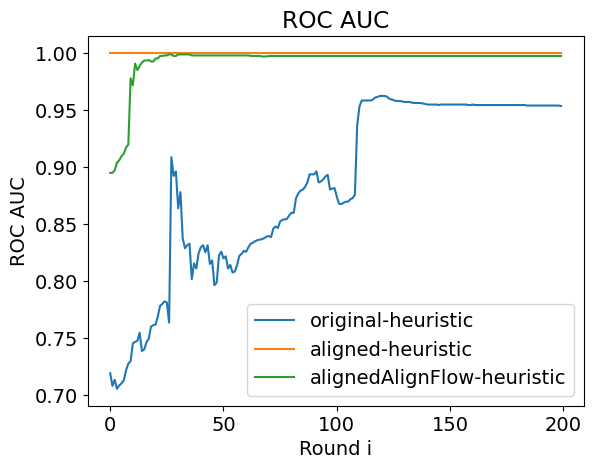

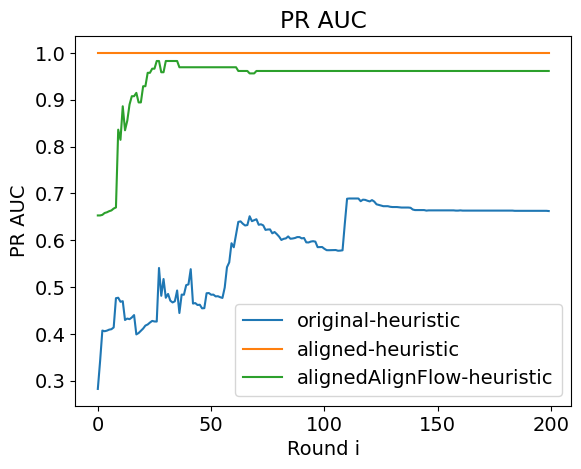

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["roc"]
import csv
with open('auc_roc.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    label = line[0]
    if label[0] == 'X':
        ax.plot([float(i) for i in line[1:]], label = label[1:])
plt.title('ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Round i')
plt.legend()
fig.savefig('img/ROC AUC.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["pr"]
import csv
with open('auc_pr.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    label = line[0]
    if label[0] == 'X':
        ax.plot([float(i) for i in line[1:]], label = label[1:])
plt.title('PR AUC')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
plt.legend()
plt.show()
fig.savefig('img/PR AUC.png',bbox_inches='tight')
plt.close(fig)